In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import uproot
import awkward as ak
%matplotlib inline

In [2]:
data_path = "/scratch/elena/WCTE-DataAnalysis-PIDcuts/MCDataComperison/root_files/data/WCTE_offline_R1574S0_VME1558.root"
mc_path = "/scratch/elena/WCTE-DataAnalysis-PIDcuts/MCDataComperison/root_files/mc/pi+_260MeVc_1000evts_masked.root"

data = uproot.open(data_path)
mc = uproot.open(mc_path)

print("Data keys", data.keys())
print("MC keys", mc.keys())

Data keys ['WCTEReadoutWindows;68', 'WCTEReadoutWindows;67', 'h_n_triggers_diff;1']
MC keys ['Tracks;1', 'CherenkovDigiHits;1', 'Trigger;1', 'WCTEReadoutWindows;1']


In [3]:
data_tree = data["WCTEReadoutWindows"]
mc_tree = mc["WCTEReadoutWindows"]

print(f"Data {data_tree}:", sorted(data_tree.keys()))
print(f"MC {mc_tree}:", sorted(mc_tree.keys()))

Data <TTree 'WCTEReadoutWindows' (34 branches) at 0x7fae105dd850>: ['beamline_pmt_qdc_charges', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids', 'beamline_pmt_tdc_times', 'event_number', 'hit_mpmt_card_ids', 'hit_mpmt_slot_ids', 'hit_pmt_channel_ids', 'hit_pmt_charges', 'hit_pmt_position_ids', 'hit_pmt_times', 'led_card_ids', 'led_counters', 'led_dacsettings', 'led_event_types', 'led_gains', 'led_ids', 'led_sequence_numbers', 'led_slot_numbers', 'led_types', 'pmt_waveform_mpmt_card_ids', 'pmt_waveform_mpmt_slot_ids', 'pmt_waveform_pmt_channel_ids', 'pmt_waveform_pmt_position_ids', 'pmt_waveform_times', 'pmt_waveforms', 'readout_number', 'run_id', 'spill_counter', 'start_counter', 'sub_run_id', 'trigger_times', 'trigger_types', 'window_time']
MC <TTree 'WCTEReadoutWindows' (28 branches) at 0x7fad769f24d0>: ['beamline_pmt_qdc_charges', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_ids', 'beamline_pmt_tdc_times', 'event_number', 'hit_mpmt_card_ids', 'hit_mpmt_slot_ids', 'hit_pmt_channel_ids', 

In [12]:
#Data 

data_beam_pmt_qdc_ids = data_tree["beamline_pmt_qdc_ids"].array()
data_event_num = data_tree["event_number"].array()

print(data_beam_pmt_qdc_ids)   #array of array, each per event, i.e. jagged array
print(len(data_beam_pmt_qdc_ids)) # number of events in data in this case

print("Type of data_beam_pmt_qdc_ids:", ak.type(data_beam_pmt_qdc_ids))
print("Type of data_event_num:", ak.type(data_event_num))


print("-------------------------------------------------------------------------------------------------")

#MC

mc_beam_pmt_qdc_ids = mc_tree['beamline_pmt_qdc_ids'].array()
mc_event_num = mc_tree["event_number"].array()

print(mc_beam_pmt_qdc_ids)   #array of array, each per event, i.e. jagged array
print(len(mc_beam_pmt_qdc_ids)) # number of events in mc in this case

print("Type of mc_beam_pmt_qdc_ids:", ak.type(mc_beam_pmt_qdc_ids))
print("Type of mc_event_num:", ak.type(mc_event_num))



[[12, 13, 5, 14, 15, 7, 16, 17, 9, 18, ... 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]]
44257
Type of data_beam_pmt_qdc_ids: 44257 * var * int32
Type of data_event_num: 44257 * int32
-------------------------------------------------------------------------------------------------
[[0], [0], [0], [0], [0], [0], [0], [0], ... [0], [0], [0], [0], [0], [0], [0], [0]]
3000
Type of mc_beam_pmt_qdc_ids: 3000 * var * int32
Type of mc_event_num: 3000 * int32


In [45]:
branches = [
    'event_number',
    'hit_mpmt_card_ids',
    'hit_mpmt_slot_ids',
    'hit_pmt_channel_ids',
    'hit_pmt_position_ids',
    'hit_pmt_charges',
    'hit_pmt_times',
    'trigger_types',
    'window_time'
]

data_arrays = {name: data_tree[name].array() for name in branches}    #load arrays (branches) from the tree
mc_arrays = {name: mc_tree[name].array() for name in branches}

def make_flat_df(branch_name):
    data_flat = ak.flatten(data_arrays[branch_name], axis=None)
    mc_flat = ak.flatten(mc_arrays[branch_name], axis=None)

    df_data = pd.DataFrame({branch_name: data_flat, "source": "data"})
    df_mc = pd.DataFrame({branch_name: mc_flat, "source": "mc"})

    return pd.concat([df_data, df_mc], ignore_index=True)

#with the function above, we generate a unique df for one branch with both files info, data and mc

df = {branch: make_flat_df(branch) for branch in branches}


In [46]:
print(df['hit_pmt_charges'].head())    #MC charge is in PE, in Data is in ADC. No comversion factor to PE available yet 

   hit_pmt_charges source
0            122.0   data
1             56.0   data
2            287.0   data
3            101.0   data
4            152.0   data


In [47]:

print(df["hit_pmt_charges"].head())
print(df["hit_pmt_charges"].columns)

   hit_pmt_charges source
0            122.0   data
1             56.0   data
2            287.0   data
3            101.0   data
4            152.0   data
Index(['hit_pmt_charges', 'source'], dtype='object')


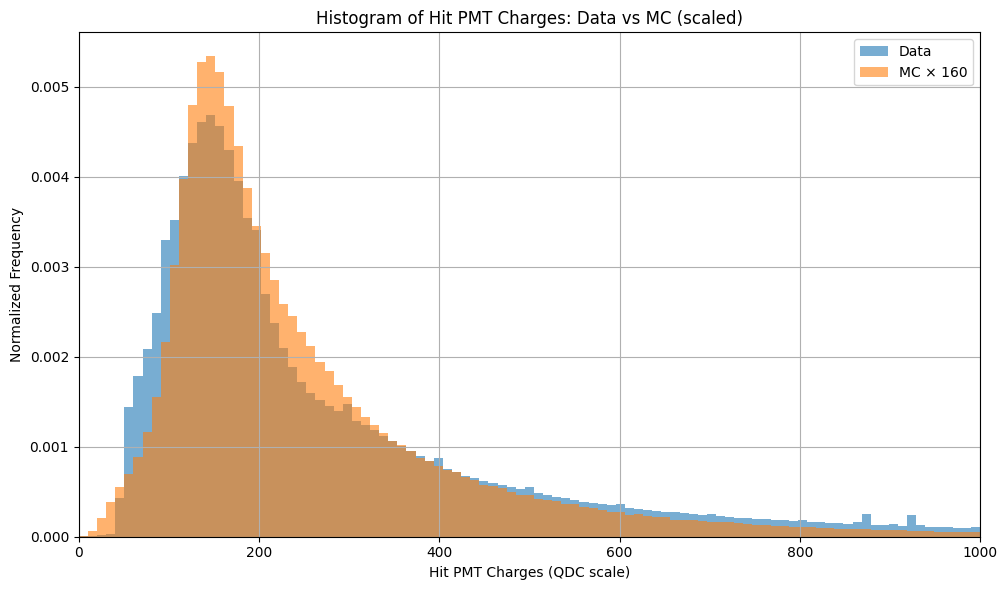

In [49]:
df_charges = df["hit_pmt_charges"]

# Aplicar máscaras para separar data vs MC
data_charges = df_charges.loc[df_charges["source"] == "data", "hit_pmt_charges"]
mc_charges = df_charges.loc[df_charges["source"] == "mc", "hit_pmt_charges"] * 160  # Escala para MC

# Filtro para limitar el rango a [0, 1000]
data_charges = data_charges[(data_charges >= 0) & (data_charges <= 1000)]
mc_charges = mc_charges[(mc_charges >= 0) & (mc_charges <= 1000)]

# Bins fijos
bins = np.linspace(0, 1000, 100)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.6, label='Data', histtype='stepfilled', density=True)
plt.hist(mc_charges, bins=bins, alpha=0.6, label='MC × 160', histtype='stepfilled', density=True)

# Estética
plt.xlabel('Hit PMT Charges (QDC scale)')
plt.ylabel('Normalized Frequency')
plt.title('Histogram of Hit PMT Charges: Data vs MC (scaled)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 1000)

plt.show()

I was trying to create a single DataFrame with all the info together, for what we needed to broadcast those flat_arrays (e.g. 'event_number', porque solo es un 1 para el evento 2, pues poner [2 2 2 2 2 2 2] para cada valor de 'hit_pmt_charge'); this is caussing problems since "trying to shove everything into a single DataFrame via ak.flatten → ak.to_pandas() is only safe if all nested structures align exactly, which in your case… they don’t."

branches = [
    'event_number',
    'hit_mpmt_card_ids',
    'hit_mpmt_slot_ids',
    'hit_pmt_channel_ids',
    'hit_pmt_position_ids',
    'hit_pmt_charges',
    'hit_pmt_times',
    'trigger_types',
    'window_time'
]

data_arrays = {name: data_tree[name].array() for name in branches}    #load arrays (branches) from the tree
mc_arrays = {name: mc_tree[name].array() for name in branches}

def broadcast_event_info(flat_array, jagged_reference):
    #if flat_array is flat (NumpyArray), broadcast it
    if isinstance(flat_array.layout, ak.layout.NumpyArray):
        broadcasted, _ = ak.broadcast_arrays(flat_array, jagged_reference)
        return broadcasted
    else:
        return flat_array #if it is already jagged, return as is (no broadcasting)

#Pasamos la función, cogemos "hit_pmt_charges" como referencia de jagged array

event_number_broadcast = broadcast_event_info(data_arrays['event_number'], data_arrays['hit_pmt_charges'])
#window_time_broadcast = broadcast_event_info(data_arrays['window_time'], data_arrays['hit_pmt_charges'])
#trigger_type_broadcast = broadcast_event_info(data_arrays['trigger_types'], data_arrays['hit_pmt_charges'])


#zip data hits
data_hits = ak.zip({
    "event_number": event_number_broadcast,
    "card_id": data_arrays['hit_mpmt_card_ids'],
    "slot_id": data_arrays['hit_mpmt_slot_ids'],
    "channel_id": data_arrays['hit_pmt_channel_ids'],
    "position_id": data_arrays['hit_pmt_position_ids'],
    "charge": data_arrays['hit_pmt_charges'],
    "time": data_arrays['hit_pmt_times']
    #"window_time": window_time_broadcast
})

#Idem for MC
event_number_broadcast_mc = broadcast_event_info(mc_arrays['event_number'], mc_arrays['hit_pmt_charges'])
#window_time_broadcast_mc = broadcast_event_info(mc_arrays['window_time'], mc_arrays['hit_pmt_charges'])
#trigger_type_broadcast_mc = broadcast_event_info(mc_arrays['trigger_types'], mc_arrays['hit_pmt_charges'])

#zip MC hits
mc_hits = ak.zip({
    "event_number": event_number_broadcast_mc,
    "card_id": mc_arrays['hit_mpmt_card_ids'],
    "slot_id": mc_arrays['hit_mpmt_slot_ids'],
    "channel_id": mc_arrays['hit_pmt_channel_ids'],
    "position_id": mc_arrays['hit_pmt_position_ids'],
    "charge": mc_arrays['hit_pmt_charges'],
    "time": mc_arrays['hit_pmt_times']
    #"window_time": window_time_broadcast_mc
})


#ak.flatten() takes the nested (jagged) array and concatenates all inner lists into one long, flat array
flat_data_hits = ak.flatten(data_hits)
flat_mc_hits = ak.flatten(mc_hits)

#pandas DataFrame
df_data = ak.to_pandas(flat_data_hits)
df_mc = ak.to_pandas(flat_mc_hits)


df_data["source"] = "data"
df_mc["source"] = "mc"


print("Data preview:")
print(df_data.head())

print("\nMC preview:")
print(df_mc.head())